In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
df=pd.read_csv('LSTM_time_series_vitals_wpatterns.csv')

In [ ]:
df.head()
#ITS IMPORTANT TO NOTE, WE HAVE 15 MIN INTERVALS OF 24-HOURS OF 10 DAYS

,timestamp,respiratory_rate,blood_oxygen,blood_sugar,systolic_bp,diastolic_bp,heart_rate
0,9/15/2023 0:00,15.924220,98.090561,91.826078,90.529788,62.087356,64.653484
1,9/15/2023 0:15,14.485640,98.896597,94.286518,97.851124,61.460963,69.114509
2,9/15/2023 0:30,15.208017,95.113089,83.681551,92.410273,65.247706,61.765431
3,9/15/2023 0:45,12.102370,95.633876,86.113478,90.784412,62.498957,64.874459
4,9/15/2023 1:00,12.188670,95.880335,99.669506,93.136733,64.067168,68.499781


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         960 non-null    object 
 1   respiratory_rate  960 non-null    float64
 2   blood_oxygen      960 non-null    float64
 3   blood_sugar       960 non-null    float64
 4   systolic_bp       960 non-null    float64
 5   diastolic_bp      960 non-null    float64
 6   heart_rate        960 non-null    float64
dtypes: float64(6), object(1)
memory usage: 52.6+ KB


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>],
      dtype=object)

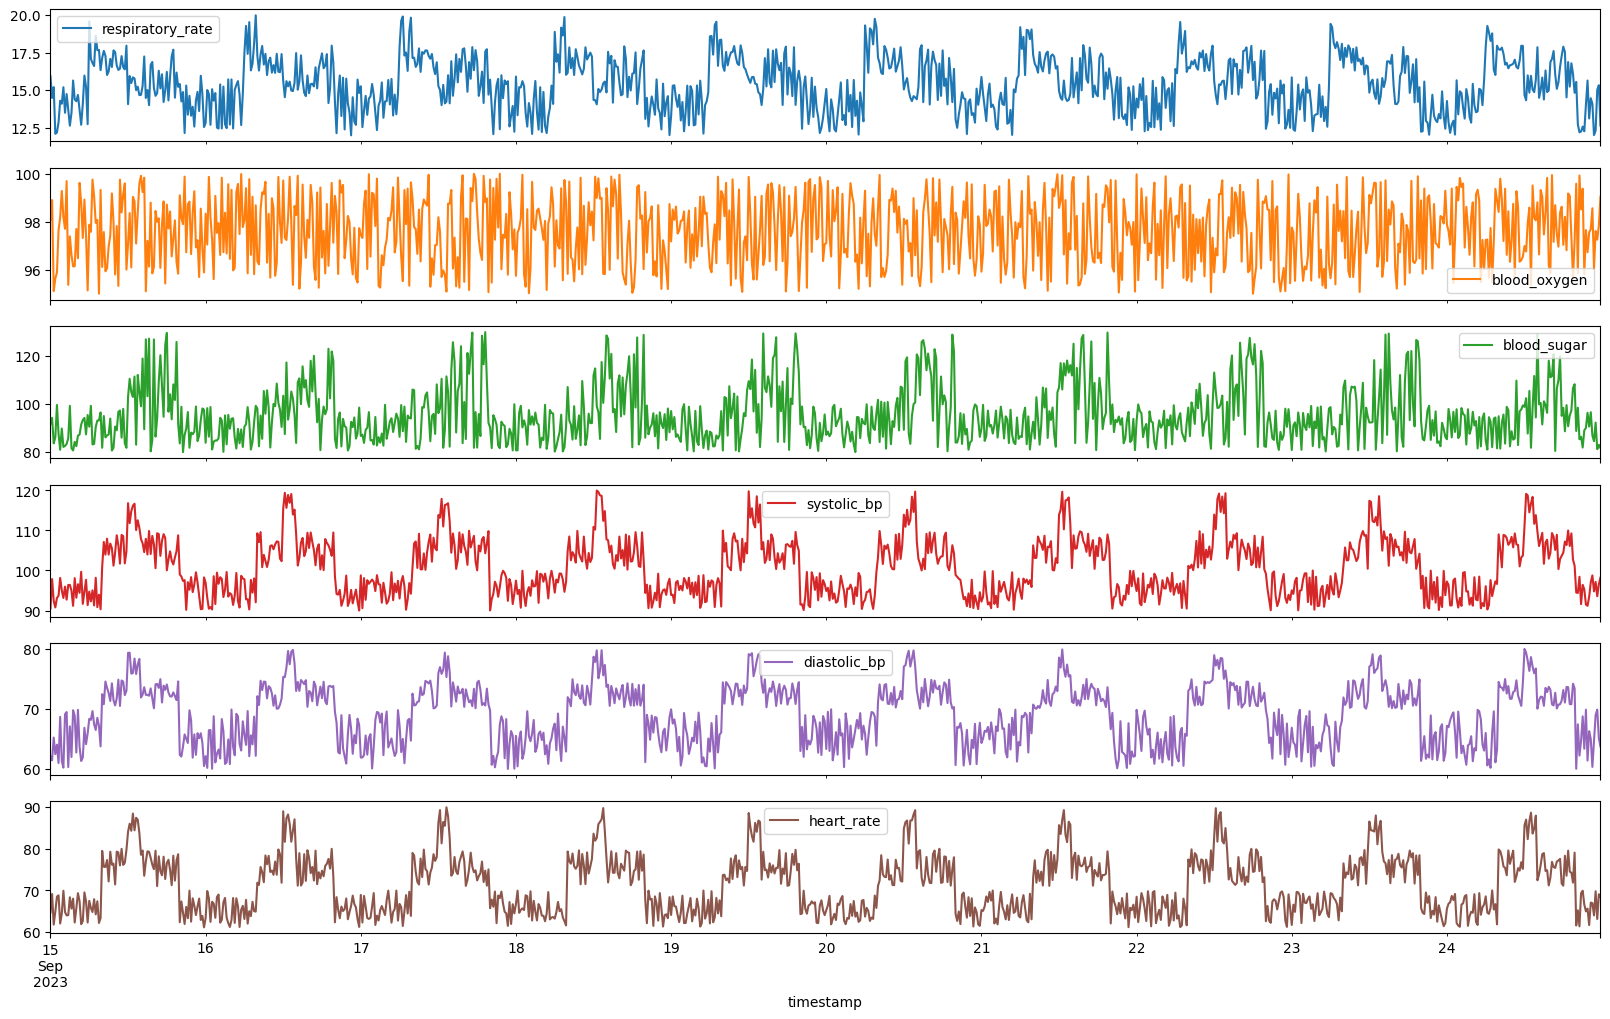

In [ ]:
#KEEP IN MIND, WE HAVE ADDED PATTERNS FOR TIME OF DAY NOW!!!
df['timestamp']=pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df.set_index('timestamp')[['respiratory_rate','blood_oxygen','blood_sugar',"systolic_bp",'diastolic_bp','heart_rate']].plot(figsize=(20,12),subplots=True)

In [ ]:
#creating new dataframe for input

df_input=df[['respiratory_rate', 'blood_oxygen','blood_sugar','systolic_bp','diastolic_bp','heart_rate']]
df_input.describe()

,respiratory_rate,blood_oxygen,blood_sugar,systolic_bp,diastolic_bp,heart_rate
count,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000
mean,15.423624,97.627473,95.678395,100.893974,69.200255,71.346869
std,1.757464,1.412755,11.772465,7.085963,4.894712,6.934234
min,12.001535,95.003005,80.019255,90.006387,60.039290,61.104360
25%,14.207833,96.360640,86.440486,95.006946,65.096752,65.463207
50%,15.401302,97.749452,93.628326,100.000794,70.002494,70.503778
75%,16.756798,98.818034,99.939477,106.279333,73.058458,76.381536
max,19.977777,99.990901,129.996983,119.969025,79.975990,89.972645


In [ ]:
#try once without scaling
#scaled to diverge faster (bw 0-1)

scaler=MinMaxScaler()
data_scaled=scaler.fit_transform(df_input)


In [ ]:
features = data_scaled[:, [0 ,1, 2, 3,4]]  # Exclude 'blood_oxygen' column
target = data_scaled[:, 5]  # Target is 'blood_oxygen' column

In [ ]:
data_scaled

array([[0.49179617, 0.61900967, 0.23624168, 0.01746843, 0.10272843,
        0.12294198],
       [0.31143798, 0.78060815, 0.28547242, 0.2618173 , 0.07130936,
        0.27747226],
       [0.40200412, 0.02207021, 0.07327855, 0.08022944, 0.26124767,
        0.02289954],
       ...,
       [0.37925757, 0.45044957, 0.02450812, 0.11922237, 0.49406712,
        0.06943755],
       [0.41778776, 0.56776461, 0.06054252, 0.21981969, 0.25660154,
        0.27563087],
       [0.08066605, 0.80834795, 0.03490021, 0.27439884, 0.18577748,
        0.25297149]])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
#[1,2,3]->[4]->[2,3,4]->5

#length 3 means the context window, taking 3 previous inputs (15,15,15) minutes
#basically using last 45 minutes of data to predict the next vitals on 15 min mark

TimeseriesGenerator(features,target,length=3,sampling_rate=1, batch_size=1)[0]

(array([[[0.49179617, 0.61900967, 0.23624168, 0.10272843, 0.12294198],
         [0.31143798, 0.78060815, 0.28547242, 0.07130936, 0.27747226],
         [0.40200412, 0.02207021, 0.07327855, 0.26124767, 0.02289954]]]),
 array([0.02596648]))

In [ ]:
#shuffle must be false as it is a time series data and order is very important
x_train,x_test,y_train,y_test=train_test_split(features,target, test_size=0.2,random_state=123, shuffle=False)

In [ ]:
x_train.shape

(768, 5)

In [ ]:
x_test.shape

(192, 5)

In [ ]:
win_len=3 #using past 45 mins of data to predict the next batch
batch_size=32
num_features=5
train_generator=TimeseriesGenerator(x_train, y_train, length=win_len, sampling_rate=1, batch_size=batch_size)
test_generator=TimeseriesGenerator(x_test, y_test, length=win_len, sampling_rate=1, batch_size=batch_size)

In [ ]:
import tensorflow as tf

In [ ]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape=(win_len,num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 3, 128)            68608     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 3, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 3, 128)            131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 3, 128)            0         
                                                                 
 dropout_2 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2, mode='min') #dont run forever, if 2 loss comes same, it will stop.

model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.Accuracy()])

history=model.fit(train_generator, epochs=50,validation_data=test_generator, shuffle=False, callbacks=[early_stopping])

Epoch 1/50
24/24 [==============================] - 9s 100ms/step - loss: 0.0838 - mean_absolute_error: 0.2227 - accuracy: 0.0000e+00 - val_loss: 0.0335 - val_mean_absolute_error: 0.1463 - val_accuracy: 0.0000e+00
Epoch 2/50
24/24 [==============================] - 1s 24ms/step - loss: 0.0346 - mean_absolute_error: 0.1473 - accuracy: 0.0000e+00 - val_loss: 0.0236 - val_mean_absolute_error: 0.1183 - val_accuracy: 0.0000e+00
Epoch 3/50
24/24 [==============================] - 1s 22ms/step - loss: 0.0244 - mean_absolute_error: 0.1223 - accuracy: 0.0000e+00 - val_loss: 0.0204 - val_mean_absolute_error: 0.1075 - val_accuracy: 0.0000e+00
Epoch 4/50
24/24 [==============================] - 1s 23ms/step - loss: 0.0222 - mean_absolute_error: 0.1156 - accuracy: 0.0000e+00 - val_loss: 0.0186 - val_mean_absolute_error: 0.1021 - val_accuracy: 0.0000e+00
Epoch 5/50
24/24 [==============================] - 1s 23ms/step - loss: 0.0219 - mean_absolute_error: 0.1151 - accuracy: 0.0000e+00 - val_loss: 0.

In [ ]:
model.evaluate_generator(test_generator,verbose=0)

<ipython-input-50-b08afc977308>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator,verbose=0)


[0.01835346780717373, 0.1036224290728569, 0.0]

In [ ]:
#now checking how well the model compared to against actual values
predictions=model.predict_generator(test_generator)

<ipython-input-51-e80d683d189e>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=model.predict_generator(test_generator)


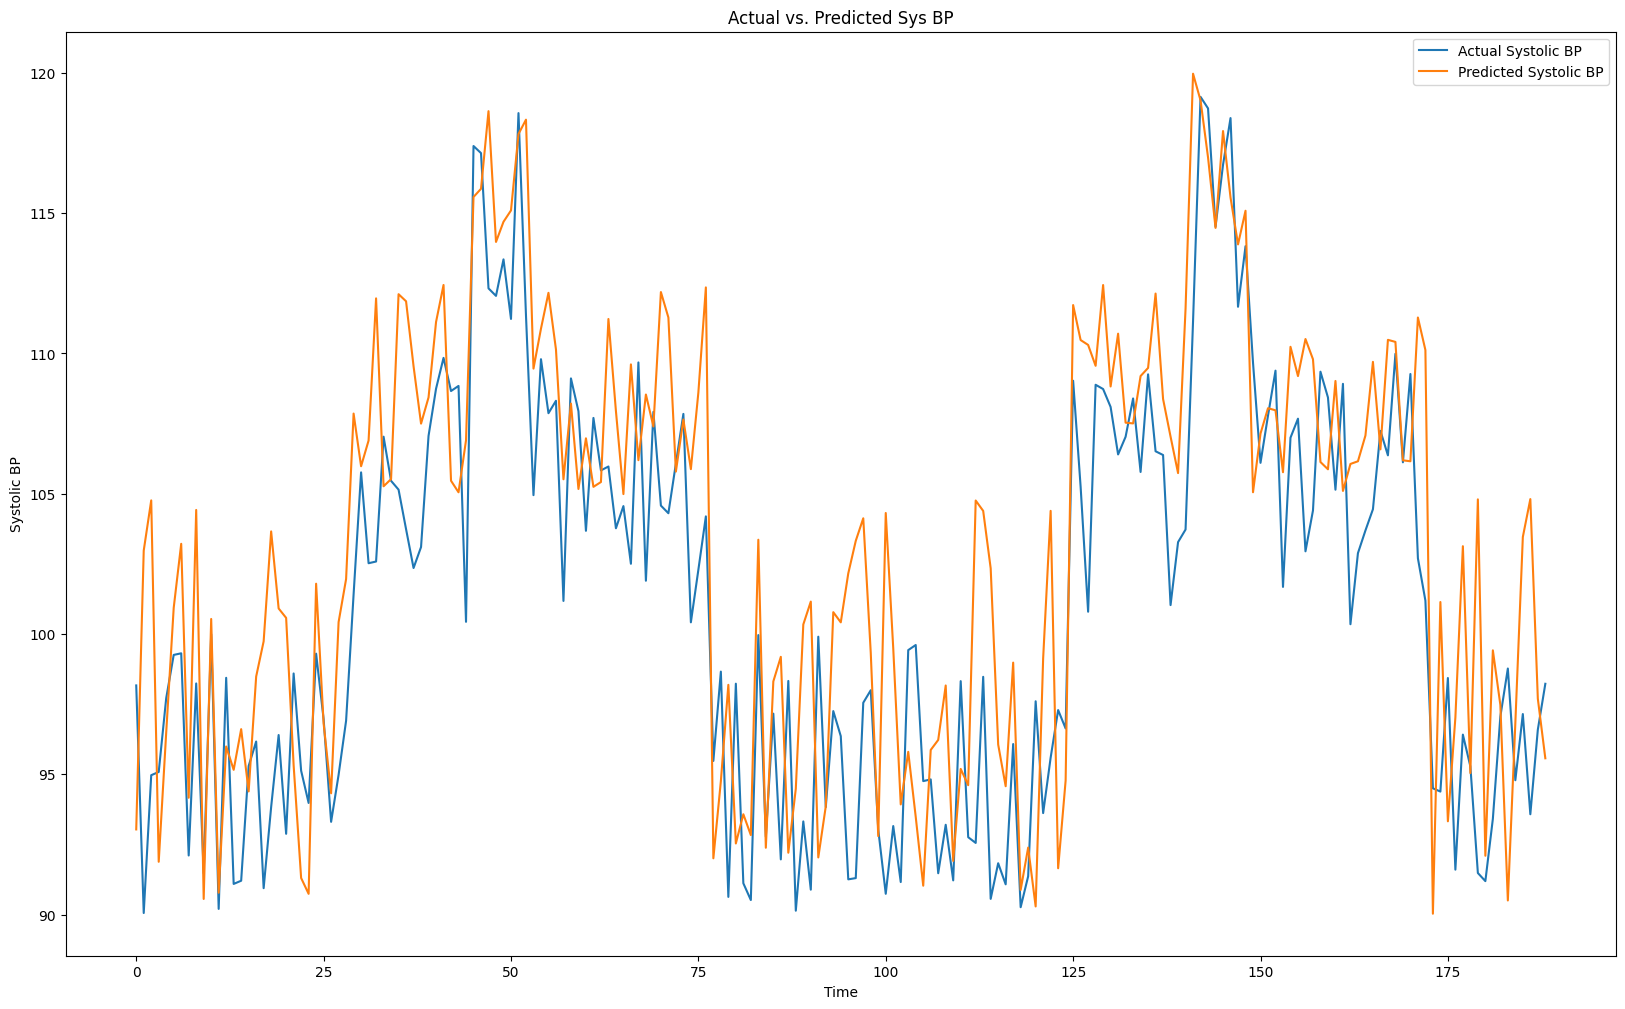

In [ ]:
predictions = scaler.inverse_transform(np.hstack((features[-len(predictions):], predictions)))

# Plot the actual and predicted Respiratory Rate values
plt.figure(figsize=(20, 12))
plt.plot(df['systolic_bp'].values[-len(predictions):], label='Actual Systolic BP', linestyle='-')
plt.plot(predictions[:, 3], label='Predicted Systolic BP', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Systolic BP')
plt.legend()
plt.title('Actual vs. Predicted Sys BP')
plt.show()

In [ ]:
predictions = scaler.inverse_transform(np.hstack((features[-len(predictions):], predictions)))

threshold = 5  # Define your acceptable error threshold here

# Calculate the absolute errors
absolute_errors = np.abs(df['heart_rate'].values[-len(predictions):] - predictions[:, 5])

# Calculate the percentage of accurate predictions
accurate_predictions = np.sum(absolute_errors <= threshold)
total_predictions = len(predictions)
percentage_accuracy = (accurate_predictions / total_predictions) * 100

print(f"Percentage Accuracy: {percentage_accuracy:.2f}%")


Percentage Accuracy: 86.24%


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Calculate MAE and RMSE (Root Mean Squared Error)
mae = mean_absolute_error(df['systolic_bp'].values[-len(predictions):], predictions[:, 3])
rmse = math.sqrt(mean_squared_error(df['systolic_bp'].values[-len(predictions):], predictions[:, 3]))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 4.11069827775708
Root Mean Squared Error (RMSE): 5.140059967540535


#STOP

In [ ]:
predictions

array([[0.19536842],
       [0.17649135],
       [0.195872  ],
       [0.25243154],
       [0.24521929],
       [0.22191389],
       [0.2094234 ],
       [0.2616814 ],
       [0.25154805],
       [0.2637095 ],
       [0.21690738],
       [0.22656536],
       [0.14564185],
       [0.17273921],
       [0.15910135],
       [0.18825807],
       [0.1736079 ],
       [0.17371143],
       [0.18269034],
       [0.21938054],
       [0.21671642],
       [0.21739306],
       [0.23206355],
       [0.25559106],
       [0.2739795 ],
       [0.28194544],
       [0.2937378 ],
       [0.28193423],
       [0.27550298],
       [0.27235726],
       [0.3697123 ],
       [0.45436454],
       [0.50377053],
       [0.5165475 ],
       [0.58150786],
       [0.555481  ],
       [0.53495204],
       [0.5451811 ],
       [0.5523381 ],
       [0.52001745],
       [0.55292565],
       [0.58760816],
       [0.6232291 ],
       [0.63690245],
       [0.6051116 ],
       [0.546103  ],
       [0.61468405],
       [0.763

In [ ]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_len:])], axis=1)

In [ ]:
rev_trans=scaler.inverse_transform(df_pred)

In [ ]:
df_final=df_input[predictions.shape[0]*-1:]

In [ ]:
df_final['pred_systolic_bp']=rev_trans[:,0]

<ipython-input-132-7ee4f77d86cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['pred_systolic_bp']=rev_trans[:,0]


<Axes: >

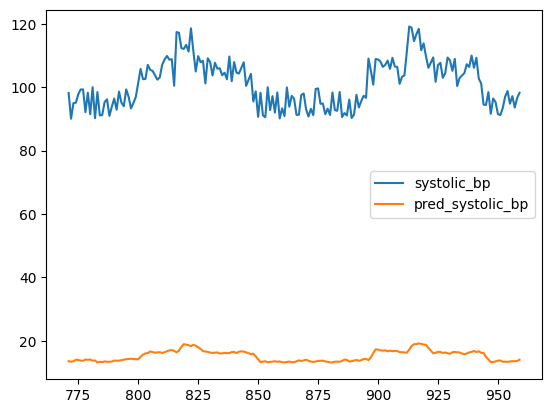

In [ ]:
df_final[['systolic_bp','pred_systolic_bp']].plot()